Using TensorFlow backend.


C:\Users\herma\Apps\master-thesis\src\utils
C:\Users\herma\Apps\master-thesis
Columns before removal: 
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20PT001 - Gas side inlet pressure
Col. 2 : 20FT001 - Gas side flow
Col. 3 : 20TT002 - Gas side outlet temperature
Col. 4 : 20PDT001 - Gas side pressure difference
Col. 5 : 50TT001 - Cooling side inlet temperature
Col. 6 : 50PT001 - Cooling side inlet pressure
Col. 7 : 50FT001 - Cooling side flow
Col. 8 : 50TT002 - Cooling side outlet temperature
Col. 9 : 50PDT001 - Cooling side pressure differential
Col. 10 : 50TV001 - Cooling side valve opening

Columns after removal: 
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20FT001 - Gas side flow
Col. 2 : 20TT002 - Gas side outlet temperature
Col. 3 : 20PDT001 - Gas side pressure difference
Col. 4 : 50TT001 - Cooling side inlet temperature
Col. 5 : 50TT002 - Cooling side outlet temperature

Finding data between 2020-01-01 00:00:00 and 2020-03-20 00:00:00
Found 315 rows

Finding d

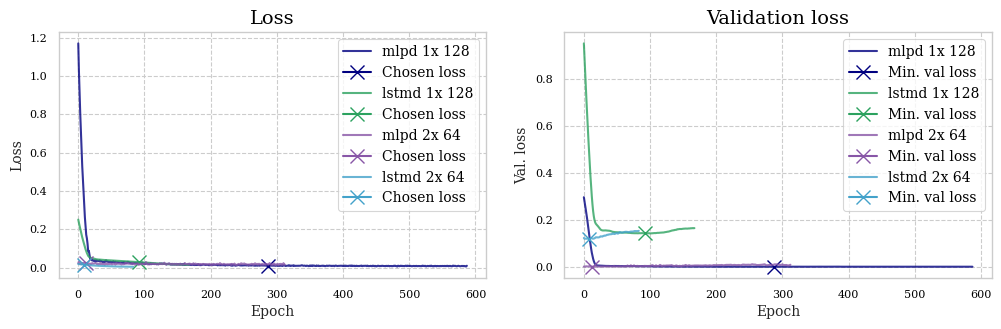

Model prediction scores
+------------------------+-------------+------------+
|         Model          | Train score | Test score |
+------------------------+-------------+------------+
|      mlpd 1x 128       |    0.9986   |   0.9061   |
|      lstmd 1x 128      |    0.8795   |   0.6656   |
|       mlpd 2x 64       |    0.9948   |   0.8199   |
|      lstmd 2x 64       |    0.8859   |   0.7227   |
| mlp2 + linear ensemble |    0.9984   |   0.848    |
| lstm2 + mlp2 ensemble  |    0.9982   |   0.8057   |
|        linear r        |    0.9938   |   0.934    |
+------------------------+-------------+------------+


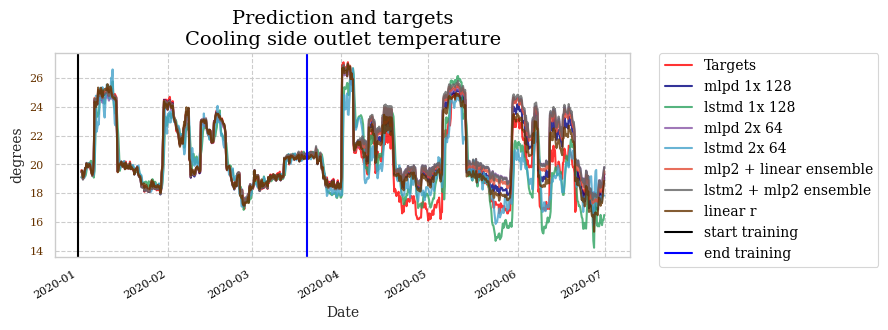

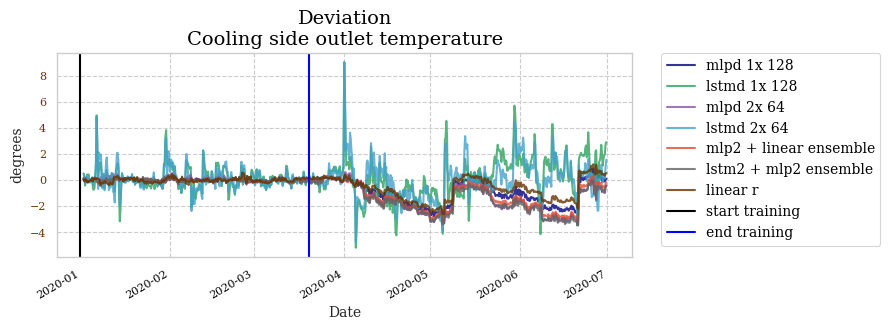

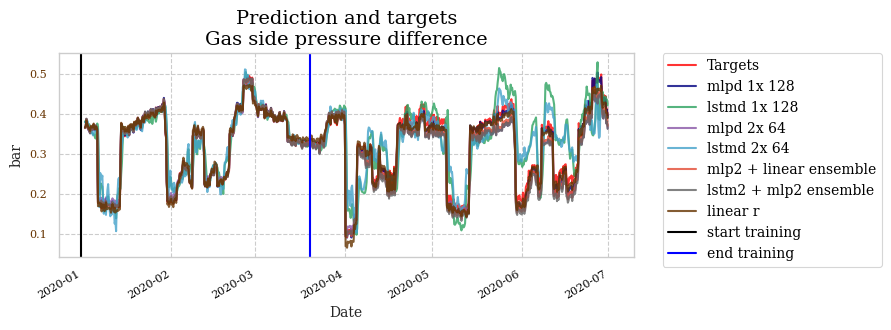

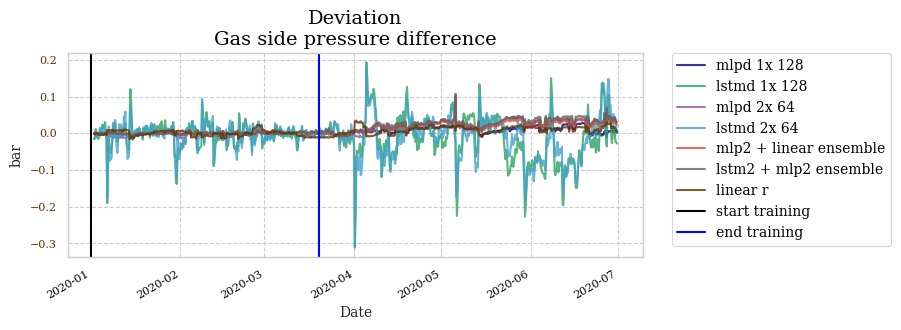

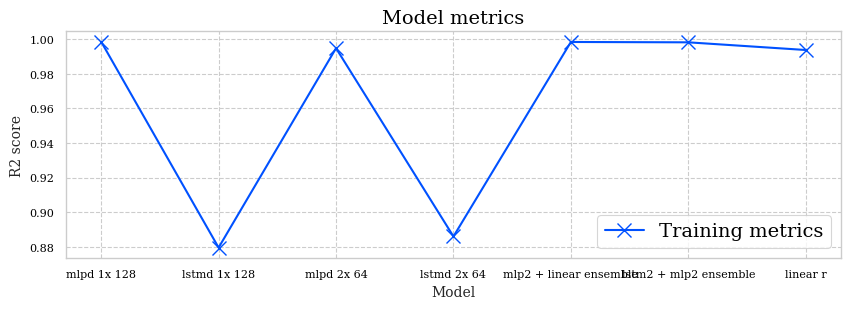

In [1]:
# %load example_D_basic.py
import src.core as mlApi

# 1. Define dataset specifics

# File path to dataset .csv file
filename = "../master-thesis-db/datasets/D/dataC.csv"

# List of columns on form ['name', 'desc', 'unit']
columns = [
    ['20TT001', 'Gas side inlet temperature', 'degrees'],
    ['20PT001', 'Gas side inlet pressure', 'barG'],
    ['20FT001', 'Gas side flow', 'M^3/s'],
    ['20TT002', 'Gas side outlet temperature', 'degrees'],
    ['20PDT001', 'Gas side pressure difference', 'bar'],
    ['50TT001', 'Cooling side inlet temperature', 'degrees'],
    ['50PT001', 'Cooling side inlet pressure', 'barG'],
    ['50FT001', 'Cooling side flow', 'M^3/s'],
    ['50TT002', 'Cooling side outlet temperature', 'degrees'],
    ['50PDT001', 'Cooling side pressure differential', 'bar'],
    ['50TV001', 'Cooling side valve opening', '%'],
]

# List of column names to ignore completely
irrelevantColumns = [
    '20PT001',
    '50PT001',
    '50FT001',
    '50PDT001',
    '50TV001',
]

# List of column names used a targets
targetColumns = [
    '50TT002',
    '20PDT001',
]

# List of training periods on form ['start', 'end']
traintime = [
    ["2020-01-01 00:00:00", "2020-03-20 00:00:00"],
]

# Testing period, recommended: entire dataset
testtime = [
    "2020-01-01 00:00:00",
    "2020-08-01 00:00:00"
]

# 2. Initiate and divide data

df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

# 3. Define models
mlpd_1x_128 = mlApi.MLP('mlpd 1x 128', layers=[128], dropout=0.2)
lstmd_1x_128 = mlApi.LSTM('lstmd 1x 128', layers=[128], dropout=0.2, recurrentDropout=0.2, enrolWindow=3)
mlpd_2x_64 = mlApi.MLP('mlpd 2x 64', layers=[64, 64], dropout=0.2)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x 64', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, enrolWindow=3)
linear_r = mlApi.Linear_Regularized('linear r')
ensemble1 = mlApi.Ensemble('mlp2 + linear ensemble', [mlpd_2x_64, linear_r])
ensemble2 = mlApi.Ensemble('lstm2 + mlp2 ensemble', [mlpd_2x_64, lstmd_2x_64])

modelList = [
    mlpd_1x_128,
    lstmd_1x_128,
	mlpd_2x_64,
	lstmd_2x_64,
    ensemble1,
    ensemble2,
	linear_r,
]

# 4. Initiate and train models

# Define whether to retrain models or not
retrain=False

mlApi.initModels(modelList)
mlApi.trainModels(retrain)
modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlApi.predictWithModels(
	plot=True,
	interpol=False,
)

